In [3]:
# importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from prettytable import PrettyTable
import os
import random as rn

# settings
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis

In [4]:
# loading the training data 
train_data = pd.read_csv("data/train.csv")

## Defining Utility Functions

In [ ]:
def plot_histogram(data,title,xlabel,ylabel,num_bins):
    '''
    Function to plot histogram from the given input series
    '''
    
    # plotting histogram
    plt.figure(figsize=(8,6))
    plt.title(f"{title}")
    sns.histplot(data=data,bins=num_bins,palette="rocket")
    plt.xlabel(f"{xlabel}")
    plt.ylabel(f"{ylabel}")
    
    return plt.show()

def count_plot(data,x,title):
    '''
    Function to plot count plot for the given input data
    '''
    
    # plotting countplot
    plt.figure(figsize=(6,6))
    plt.title(f"{title}")
    sns.countplot(x=x,data=data,palette="rocket")
    
    return plt.show()
    
    
def binary_labels(data):
    '''
    Function returns binary labelled data for EDA purposes
    '''
    
    # creating a copy
    data = data.copy()
    
    # toxicity type list
    toxicity_types = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
    
    # labelling as either toxic or clean
    data["is_toxic"] = data[toxicity_types].any(axis="columns")
    
    # dropping columns not required
    data.drop(labels=toxicity_types,axis=1,inplace=True)
    
    return data

def violin_plot(data,x,y,title):
    '''
    Function to plot violin plot based on input data
    '''
    
    # plotting violin plot
    plt.figure(figsize=(8,6))
    sns.violinplot(x=x,y=y,data=data,palette="rocket")
    plt.title(f"{title}")
    
    return plt.show()

def plot_bar(data,x,y,title):
    '''
    Function plot a bar plot based on input data
    '''
    
    # plotting bar plot
    plt.figure(figsize=(8,6))
    sns.barplot(x=x,y=y,data=data,palette="rocket")
    plt.title(f"{title}")
    
    return plt.show()

    
def add_clean(data):
    '''
    Function to add clean comment label to data
    '''
    
    # creating a copy
    data = data.copy()
    
    # toxicity type list
    toxicity_types = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
    
    # adding clean label
    data["is_clean"] = ~data[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]].any(axis="columns")
    
    return data

def count_labels(data):
    '''
    Function to count instances of various class labels 
    '''
    
    # toxicity type list
    toxicity_types = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
    
    # getting counts of each toxicity type
    counts = []
    for label in toxicity_types:
        count = sum(data[label])
        counts.append(count)
    
    # creating a dataframe
    count_df = pd.DataFrame(columns=["label","count"])
    count_df["label"] = toxicity_types
    count_df["count"] = counts
    
    return count_df
    

def add_num_tags(data):
    '''
    Function computes number of tags attached to each comment 
    '''
    
    # creating a copy
    data = data.copy()
    
    # toxicity type list
    toxicity_types = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
    
    # adding num_tags column
    data["num_tags"] = data[toxicity_types].sum(axis=1)
    
    return data

def example_comments(data,label):
    '''
    Function returns an example comment based on the input label
    '''
    
    # creating a copy
    data = data.copy()
    
    # adding the clean label
    data = add_clean(data)
    data["is_clean"] = data["is_clean"].apply(lambda x: int(x))
    
    # filtering out based on input label
    filtered_data = data[data[label]==1]
    
    # getting a sample comment
    sample_comment = filtered_data.sample(n=1)["comment_text"].values[0]
    
    # printing the comment 
    print(f"Sample Comment: {label}")
    print("")
    print(sample_comment)
    print("")
    print("*"*130)
    
def plot_wordcloud(data,label):
    '''
    Function to plot word cloud for comments of different labels  
    '''
    
    # toxicity type list
    toxicity_types = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
    
    # setting up the figure
    plt.figure(figsize=(4,4))
    
    # set of stopwords
    stopwords = set(STOPWORDS)
    
    # filtering comment text based on input label  
    filtered_data = data[data[label]==1]

    # processing the input text 
    corpus = filtered_data["comment_text"]
    result = ""
    for sentence in corpus:
        result += sentence + " "
        result = result.lower()

    # generating wordcloud
    wordcloud = WordCloud(width = 800, height = 800,
            background_color ='white',
            stopwords = stopwords,
            min_font_size = 10).generate(result)
    
    print(f"WordCloud: {label} comments")

    # plot the WordCloud image   
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)
        
    return plt.show()

def correlation_heatmap(data):
    '''
    Function to plot correlation heatmap between our different labels
    '''
    
    # making a copy and filtering required columns
    data = data.copy()
    toxicity_types = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
    data = data[toxicity_types]
    
    # correlation matrix
    corr_matrix = data.corr()
    
    # plotting heatmap 
    plt.figure(figsize=(8,6))
    sns.heatmap(corr_matrix,annot=True,vmin=1,vmax=0,fmt='.2g',cmap='rocket')
    plt.title("Correlation Matrix: Comment Labels")
    
    return plt.show()

In [ ]:
# sample points
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
# shape pf data
train_data.shape

(159571, 8)

In [ ]:
# analysing missing values in the data
for column in train_data.columns:
    null_count = sum(train_data.isnull()[column])
    print(f"{column}: {null_count} null values")

id: 0 null values
comment_text: 0 null values
toxic: 0 null values
severe_toxic: 0 null values
obscene: 0 null values
threat: 0 null values
insult: 0 null values
identity_hate: 0 null values


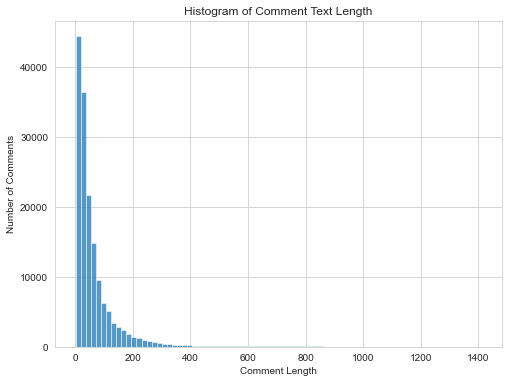

In [ ]:
# histogram of comment_text lenghts

# finding length of comments
comment_lengths = train_data["comment_text"].apply(lambda x: len(x.split()))

# plotting histogram
title = "Histogram of Comment Text Length"
plot_histogram(data=comment_lengths,title=title,xlabel="Comment Length",ylabel="Number of Comments",num_bins=80)


**Plot Description** 

The above plot depicts the distribution of comment lengths in our corpus. On the x-axis two consecutive ticks represent the minimum and maximum bin values for comment length and on the y-axis we have the corresponding number of comments having length within the bin range.

**Plot Analysis**

As observed from the above plot most of the comments have very few words around 0-60. In a few cases we can see that comments have more than 200 words. Comments having more than 200 words is a very rare occurence. 

**Plot Conclusion**

Generally it is said that the length of comments posted on online discussion forums follows a log normal distribution. Based on our observations we can also conclude that the comment length of our document corpuse follows a log normal distribution as there are a large number of short comments and very few instances of longer comments. We can further analyze the length of comment text using percentiles.

In [ ]:
# analysing percentile value of comment lengths
for i in range(0,110,10):
    value = np.percentile(a=comment_lengths,q=i)
    print(f"{i}th Percentile Value: {value}")

0th Percentile Value: 1.0
10th Percentile Value: 8.0
20th Percentile Value: 14.0
30th Percentile Value: 20.0
40th Percentile Value: 27.0
50th Percentile Value: 36.0
60th Percentile Value: 47.0
70th Percentile Value: 63.0
80th Percentile Value: 91.0
90th Percentile Value: 152.0
100th Percentile Value: 1411.0


As seen from the percentile analysis above, around 90% of comments have less than 150 words. There is a very big gap between the 90th and 100th percentile value, hence we will be zooming in further.


In [ ]:
# zooming in the percentile values
for i in range(90,101):
    value = np.percentile(a=comment_lengths,q=i)
    print(f"{i}th Percentile Value: {value}")

90th Percentile Value: 152.0
91th Percentile Value: 163.0
92th Percentile Value: 175.0
93th Percentile Value: 188.0
94th Percentile Value: 207.0
95th Percentile Value: 230.0
96th Percentile Value: 258.0
97th Percentile Value: 302.0
98th Percentile Value: 386.0
99th Percentile Value: 567.0
100th Percentile Value: 1411.0


As seen from the zoomed in analysis, 95% of the comments in the training corpus have less than 230 words. Furthermore, only 1% of comments have more than 500 words. Let's pull out a few sample comments which have a lot of words.

In [ ]:
# sample comment text with > 500 words

# adding comment length column to data
train_data["comment_length"] = train_data["comment_text"].apply(lambda x: len(x.split())) 

# comments with > 500 words
long_comments_df = train_data[train_data["comment_length"]>500]



In [ ]:
for index,row in long_comments_df.sample(n=2).iterrows():
    print(row["comment_text"])
    print("*"*130)

"

 I encourage you to read that essay carefully. WP is a great resource. It is an amazing resource. It is additionally useful, helpful, unprecedented, and perhaps even world changing! I love it, that's why I volunteer my time here to improve articles and direct people to resources that can help answer their questions. But none of that makes it reliable, not in WP's own terminology. The scientific theory article is a great example. That's actually a pretty good article. And it's useful for many purposes. But the definition is presented too simplistically, and it makes it seem that all theories are generally accepted as true explanations of the world, and that is not the case, as is demonstrated by the phlogiston theory. And that example is confusing, but there are also many many inaccuracies and outright incorrect statements on WP  I know because I've fixed a few. Some are accidental, some are malicious, some will be soon fixed, but others linger. Another thing to remember is WP is alw

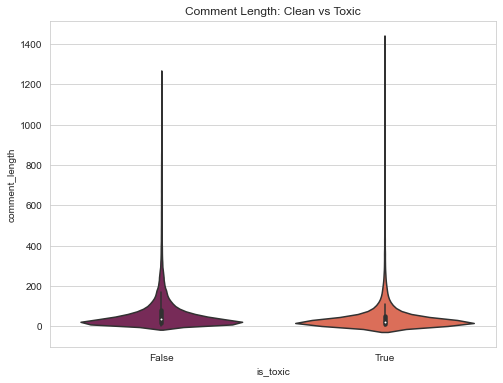

In [ ]:
# word count of toxic vs clean comments 
# plotting violin plot
title = "Comment Length: Clean vs Toxic"
violin_plot(data=binary_labels(train_data),x="is_toxic",y="comment_length",title=title)

**Plot Description** 

The above plot compares the distribution of comment word count between toxic and clean comments. On the x-axis we have the two categories of comments and on the y-axis we have the comment length values. 

**Plot Analysis**

As observed from the plot distribution of comment length in case of toxic comments is right skewed. Similary, for clean or non-toxic comments, most of the comments are limited to a few words with few instances of long comments

**Plot Conclusion**

Based on the above observation, we can conclude that there is no separate patterns in terms of word count between toxic and clean comments. 

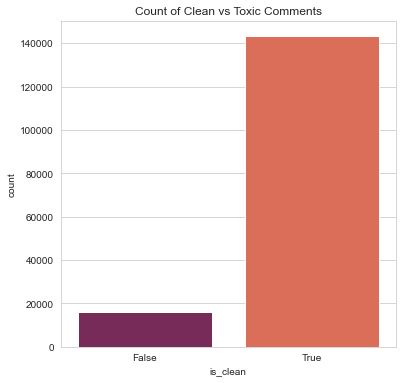

In [ ]:
# count plot of clean vs toxic comments
title="Count of Clean vs Toxic Comments"
count_plot(data=add_clean(train_data),x="is_clean",title=title)

**Plot Description** 

The above plot compares the count of toxic and clean comments. On the x-axis we have the boolean labels representing if the comment is clean or not and on the y-axis we have the count of the two different categories of comments in our corpus.  

**Plot Analysis**

The number of toxic comments in the corpus is around 16k. On the other hand, there are over 140k clean comments which represents around 90% of the total comments. Hence, the ratio of toxic comments to clean comments is approximately around 1:9.

**Plot Conclusion**

Based on the plot analysis, we can conclude that we have a highly imbalanced dataset in terms of clean vs toxic comments. This is intuitive because in online discussion forums most of the comments are posted with a positive intent. However, in terms of our classification problem we need to be mindful of this imbalance while creating our models.  

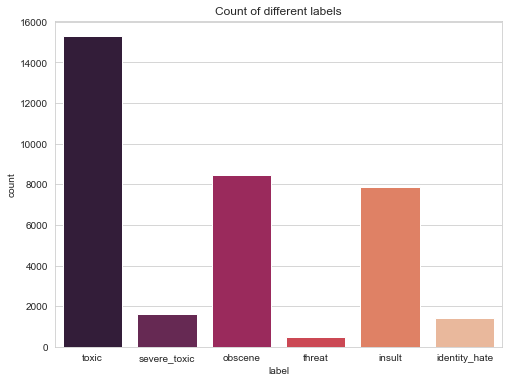

In [ ]:
# comparision of counts of different labels
title = "Count of different labels"
plot_bar(data=count_labels(train_data),x="label",y="count",title=title)

**Plot Description** 

The above plot represents the count of the different toxicity lables in our training corpus. On the x-axis we have the different labels and the y-axis depitcs the counts of each label.

**Plot Analysis**

The label "toxic" has the highest number of instances (around 15k) amongst all the different classes. Comments with obscene and insult comments have approximately the same number of count in the dataset at around 8k comments. Contrarily, threat based comments are very rare and have fewer than 1k instances.

**Plot Conclusion**

Previosuly we observed that there was an imbalance between clean and toxic comments. Based on the observations of this plot we can further conclude that there is an imbalance within the different toxic labels as well.

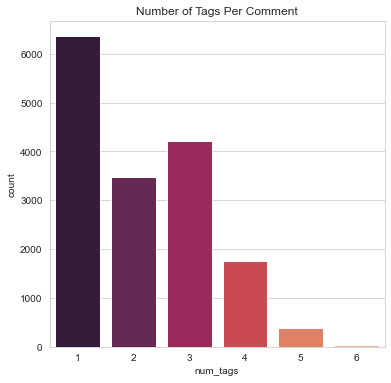

In [ ]:
# count plot of number of tags per comment
title = "Number of Tags Per Comment"
temp_data = add_num_tags(train_data)

# filtering out those comments who have at least 1 tag
temp_data = temp_data[temp_data["num_tags"]>0]
count_plot(data=temp_data,x="num_tags",title=title)

**Plot Description** 

The above plot shows the count of comment texts based on the number of tags attached to them. On the x-axis we have the different number of tags attached to a comment and on the corresponding y-axis we have the counts of comments.

**Plot Analysis**

As observed from the plot, most toxic comments have only a single tag attached to them. However, there are also instances of approximately 3.5k and over 4k comments with 2 and 3 tags attached to them respectively. Furthermore, there are also a small portion of comments having all toxic labels as positive.

**Plot Conclusion**

Based on the above observations, we can conclude that a given comment can have multiple toxicity tags attached to it.

Now let's look at some examples of each of the different types of toxicity in our dataset as well as a clean comment.

In [ ]:
# printing the sample comments for each label

labels = ["is_clean","toxic","severe_toxic","obscene","threat","insult","identity_hate"]
for label in labels:
    example_comments(data=train_data,label=label)



Sample Comment: is_clean

"

I think it's time to deal with content now. As I said, her personal life, I'm afraid to add unencyclopedic content but her childhood is written here: . I think it's important to write what kind of a girl she was. So please tell me what do you think? What should and what shouldn't be added from these links and how? Please help...:)  • Talk2me "

**********************************************************************************************************************************
Sample Comment: toxic

I'm not here to answer your dumb questions or fix your mistakes.

Your actions are completely counterproductive, malicious, hateful, and unhelpful.  Leave Haber alone.  You have nothing to do with anything I've said.  I'd like to flame the hell out of you, but I know you're just a child, so I'll hold back.  Why don't you mind your own business?  Is it because Ben Franklin propagated the phrase and you hate Americans?  Don't be a bigot, guy.  May you reap what you ha

WordCloud: toxic comments


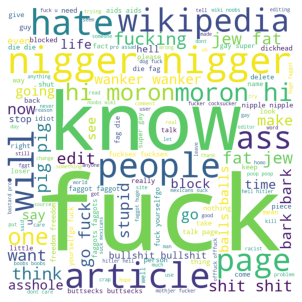

WordCloud: severe_toxic comments


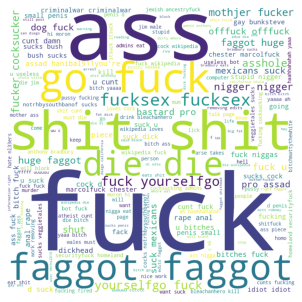

WordCloud: obscene comments


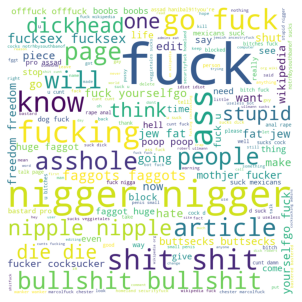

WordCloud: threat comments


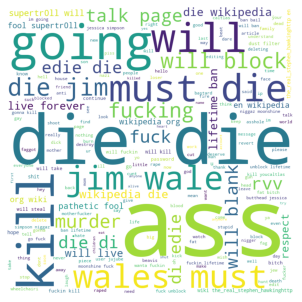

WordCloud: insult comments


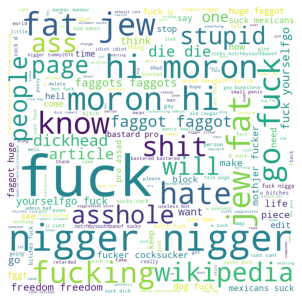

WordCloud: identity_hate comments


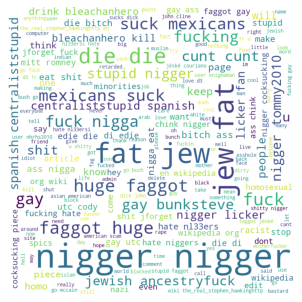

In [ ]:
# wordcloud for different labels
labels = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
for label in labels:
    plot_wordcloud(data=train_data,label=label)

**Plot Description** 

The above plots represent the most commonly found words for each type of labels in  our training corpus. The larger the font size for a given word, higher is its frequency of appearing within the given label.





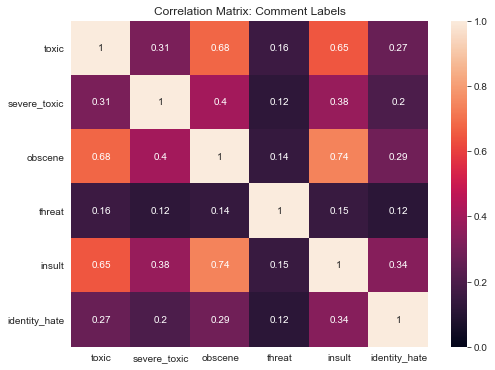

In [ ]:
# correlation matrix of different class labels
correlation_heatmap(data=train_data)

**Plot Description** 

The above heatmap tries to depict the correlation between the different class labels. A lower value represents a lower correlation value between two labels and vice versa.

**Plot Analysis**

It can be observed from the plot that obscene and insult based comments have the highest correlation coefficent compared to any other pair of labels. This indicates that there is a very high chance that both the labels are tagged to the same sentence. Contrarily, threat and severe toxic comments have the lowest correlation coefficent of around 0.12.

**Plot Conclusion**

Based on our observation and analysis, we can conclude that there are certain pairs of labels that have a higher probability of occuring together.

# Data Processing

Under this section we will be processing the data by applying text normalization and other standard preprocessing steps for NLP based classification tasks

## Defining Utility Functions

In [5]:
def remove_duplicates(data):
    '''
    Function to remove rows with duplicate text in our data
    '''
    
    # dropping duplicate texts
    data.drop_duplicates(subset="comment_text",keep="first")
    
    return data


# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    '''
    This function decontracts words like won't to will not
    '''

    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

def process_before_mapping(corpus,stopwords):
    '''
    Function to process comments before profanity words mapping
    '''
    
    processed_comments = []
    
    # looping through each comment in corpus
    for comment in tqdm(corpus):
        
        # removing html tags and urls
        comment = re.sub(r'http:\S+','',comment)
        comment = BeautifulSoup(comment,"html.parser").get_text()
        
        # applying decontration
        comment = decontracted(comment)
        
        # removing non-printable characters
        comment = comment.replace('\\r', ' ')
        comment = comment.replace('\\n', ' ')
        comment = comment.replace('\\"', ' ')
        
        # removal of stopwords and lowering text 
        # https://gist.github.com/sebleier/554280
        comment = ' '.join(e for e in comment.split() if e.lower() not in stopwords)
        processed_comments.append(comment.lower().strip())
    
    return processed_comments
        
def get_vocab(corpus):
    '''
    Function returns unique words in document corpus
    '''
    # vocab set
    unique_words = set()
    
    # looping through each document in corpus
    for document in tqdm(corpus):
        for word in document.split(" "):
            if len(word) > 2:
                unique_words.add(word)
    
    return unique_words

def create_profane_mapping(profane_words,vocabulary):
    '''
    Function creates a mapping between commonly found profane words and words in 
    document corpus 
    '''
    
    # mapping dictionary
    mapping_dict = dict()
    
    # looping through each profane word
    for profane in tqdm(profane_words):
        mapped_words = set()
        
        # looping through each word in vocab
        for word in vocabulary:
            # mapping only if ratio > 80
            try:
                if fuzz.ratio(profane,word) > 80:
                    mapped_words.add(word)
            except:
                pass
                
        # list of all vocab words for given profane word
        mapping_dict[profane] = mapped_words
    
    return mapping_dict

def replace_words(corpus,mapping_dict):
    '''
    Function replaces obfuscated profane words using a mapping dictionary
    '''
    
    processed_corpus = []
    
    # iterating over each document in the corpus
    for document in tqdm(corpus):
        
        # splitting sentence to word
        comment = document.split()
        
        # iterating over mapping_dict
        for mapped_word,v in mapping_dict.items():
            
            # comparing target word to each comment word 
            for target_word in v:
                
                # each word in comment
                for i,word in enumerate(comment):
                    if word == target_word:
                        comment[i] = mapped_word
        
        # joining comment words
        document = " ".join(comment)
        document = document.strip()
                    
        processed_corpus.append(document)
        
    return processed_corpus

def final_processing(corpus):
    '''
    Function applies final processing steps post profane mapping such as removing special characters,
    punctuations etc.
    '''
    processed_comments = []
    
    # looping through each comment in corpus
    for comment in tqdm(corpus):
        comment = re.sub('[^A-Za-z\s]+',"", comment) # retain only letters
        comment = " ".join(comment.split())
        
        processed_comments.append(comment)
    
    return processed_comments

### Identifying & Removing Duplicate Comments

In [6]:
# rows of data before duplicates removal
rows_before = train_data.shape[0]

# removing duplicate comments
train_data = remove_duplicates(train_data)

# rows after 
rows_after = train_data.shape[0]

print(f"{rows_before - rows_after} duplicate comments found and removed")

0 duplicate comments found and removed


### Processing Before Profane Mapping

As part of the processing phase, we intend to replace manipulated profane words using a custom mapping. However, before proceeding with this step we need to clean our data without affecting non-alphanumeric characters generally used for manipuation. At this stage, we will be applying the following processing:

- Removal of html tags and urls
- Expanding contractions
- Removal of non-printable characters
- Stopwords removal
- Converting to lowercase

In [7]:
# set of stopwords
stopwords_list = stopwords.words("english")

In [8]:
# few example comments before processing
sample_index = [15980,11387]

for i in sample_index:
    print(train_data.loc[i,"comment_text"])
    print("*"*130)

"

PS, regarding the use of Nazi or Germany. Since Nazi refers to and simply means National Socialist, it's just more precise than saying just ""Germany"" that has much broader meaning. In the context I'd use ""Nazi Germany""  that means - National Socialist Germany.  "
**********************************************************************************************************************************
"

 Kelly Ramsey Building 

http://en.wikipedia.org/wiki/Kelly_Ramsey_Building 
Reference 7 is incorrect. It is linked to Kellyramsey.com. Please update this to kellyramsey.ca.

Thanks  — Preceding unsigned comment added by 70.74.160.18   

 File:Peter_Lougheed.jpg 
You reverted an edit of mine to File:Peter_Lougheed.jpg making it say again that it will be only be used on  one article, when quite clearly it is not being used that way, as it is being shown on at least seven. If that flys in the face of the Wikipedia policy surrounding non-free images, I felt you should know.   
I uploaded the

In [9]:
# applying processing function
train_data["comment_text"] = process_before_mapping(corpus=train_data["comment_text"],stopwords=stopwords_list)

100%|████████████████████████████████████████████████████████████████████████| 159571/159571 [00:23<00:00, 6787.01it/s]


In [10]:
# few example comments after processing
sample_index = [15980,11387]

for i in sample_index:
    print(train_data.loc[i,"comment_text"])
    print("*"*130)

" ps, regarding use nazi germany. since nazi refers simply means national socialist, precise saying ""germany"" much broader meaning. context would use ""nazi germany"" means - national socialist germany. "
**********************************************************************************************************************************
" kelly ramsey building reference 7 incorrect. linked kellyramsey.com. please update kellyramsey.ca. thanks — preceding unsigned comment added 70.74.160.18 file:peter_lougheed.jpg reverted edit mine file:peter_lougheed.jpg making say used one article, quite clearly used way, shown least seven. flys face wikipedia policy surrounding non-free images, felt know. uploaded image used one article. none articles require image comprehension. believe articles following wikipedia policy non-free image use. "
**********************************************************************************************************************************


### Replacing Manipulated Profane Words

At this stage we will be replacing manipulated profane words with their true representations. In order to achieve this we will be taking the following approach:

- Building a vocabulary of unique words in our corpus
- Loading a vocabulary of known profane/abusive words
- Computing fuzzy partial ratio between vocabulary words and list of abusive words
- Creating a mapping between vocabulary and profane words having a score of >= 80
- Replacing manipulated profane words based on mapping 

In [12]:
# loading text file of profane words
# https://www.cs.cmu.edu/~biglou/resources/bad-words.txt

profane_words = []

with open("resources/bad-words.txt","r") as f:
    for word in f:
        word = word.replace("\n","")
        profane_words.append(word)

In [13]:
# unique words in vocab 
unique_words = get_vocab(corpus=train_data["comment_text"])

100%|██████████████████████████████████████████████████████████████████████| 159571/159571 [00:01<00:00, 122244.80it/s]


In [14]:
# creating mapping dict 
mapping_dict = create_profane_mapping(profane_words=profane_words,vocabulary=unique_words)

100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [03:49<00:00,  1.23s/it]


In [15]:
# storing mapping dict as pickle file 
fp = "resources/mapping_dict.pkl"
with open(fp,mode="wb") as f:
    pickle.dump(mapping_dict,f)

In [ ]:
# few example comments with profane words manipulation to bypass filters
sample_index = [120718,37322]

for i in sample_index:
    print(train_data.loc[i,"comment_text"])
    print("*"*130)

usernames stop f-cking harrasing peopel telling cant particular username. dont stop repert administrators thrown wikipedia f-cking ashole!
**********************************************************************************************************************************
threaten me! violation several wikipedia rules. little b-itch!
**********************************************************************************************************************************


In [ ]:
# replacing based on mapped words
train_data["comment_text"] = replace_words(corpus=train_data["comment_text"],
                                           mapping_dict=mapping_dict)

100%|█████████████████████████████████████████████████████████████████████████| 159571/159571 [14:11<00:00, 187.45it/s]


In [ ]:
# example comments after replacement
sample_index = [120718,37322]

for i in sample_index:
    print(train_data.loc[i,"comment_text"])
    print("*"*130)

usernames stop fucking harrasing peopel telling cant particular username. dont stop repert administrators thrown wikipedia fucking asshole
**********************************************************************************************************************************
threaten me! violation several wikipedia rules. little bitch
**********************************************************************************************************************************


### Removing Special Characters

Now that we have replaced potentially manipulated profane words, we can go ahead with the final processing steps of removing special characters and punctuations

In [ ]:
# few example comments before processing
sample_index = [76345,34123]

for i in sample_index:
    print(train_data.loc[i,"comment_text"])
    print("*"*130)

" time managed leave message without collateral vandalism reply. ""check youtube ..."" - cannot bothered provide link, waste time searching it? point - need check youtube - believe exists. question whether exists whether notable enough wikipedia dozen deleted titles confirm notable. deleted pages list: yu-gi-oh! abridged series (96 revisions deleted) yu-gi-oh: abridged series (181 revisions deleted) yu-gi-oh: abridged series (63 revisions deleted) yu-gi-oh abridged (24 revisions deleted) leave find relevant afd discussions. — (talk | contribs) "
**********************************************************************************************************************************
yeah, given thought awkward site first hour hitting it? took good twenty mins working add link, delete like could see do, get info, site messy one new user. choose take role on, moan that. certainly found one link quick considering 3 million pages said, could see small explanation sorts takes two mins top one spent 

In [ ]:
# applying final processing function
train_data["comment_text"] = final_processing(corpus=train_data["comment_text"])

100%|██████████████████████████████████████████████████████████████████████| 159571/159571 [00:01<00:00, 106142.10it/s]


In [ ]:
# few example comments after processing
sample_index = [76345,34123]

for i in sample_index:
    print(train_data.loc[i,"comment_text"])
    print("*"*130)

time managed leave message without collateral vandalism reply check youtube cannot bothered provide link waste time searching it point need check youtube believe exists question whether exists whether notable enough wikipedia dozen deleted titles confirm notable deleted pages list yugioh abridged series revisions deleted yugioh abridged series revisions deleted yugioh abridged series revisions deleted yugioh abridged revisions deleted leave find relevant afd discussions talk contribs
**********************************************************************************************************************************
yeah given thought awkward site first hour hitting it took good twenty mins working add link delete like could see do get info site messy one new user choose take role on moan that certainly found one link quick considering million pages said could see small explanation sorts takes two mins top one spent deleting link chose leave someone else explain point right place me like s

In [ ]:
# saving the processed data on disk
file_path = "data/processed_train.csv"
train_data.to_csv(file_path)

### Processing Test Data

Under this section we will be applying all the processing steps carried out for our training data on the test set as well

In [ ]:
# loading the test data 
test_data = pd.read_csv("data/test.csv")

In [ ]:
# processing prior to profane mapping
test_data["comment_text"] = process_before_mapping(corpus=test_data["comment_text"],
                                                   stopwords=stopwords_list)

100%|████████████████████████████████████████████████████████████████████████| 153164/153164 [00:22<00:00, 6713.45it/s]


In [ ]:
# unique words in vocab 
unique_words = get_vocab(corpus=test_data["comment_text"])

100%|██████████████████████████████████████████████████████████████████████| 153164/153164 [00:01<00:00, 120462.09it/s]


In [ ]:
# creating mapping dict 
mapping_dict = create_profane_mapping(profane_words=profane_words,vocabulary=unique_words)

100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [04:03<00:00,  1.30s/it]


In [ ]:
# replacing based on mapped words
test_data["comment_text"] = replace_words(corpus=test_data["comment_text"],
                                           mapping_dict=mapping_dict)

100%|█████████████████████████████████████████████████████████████████████████| 153164/153164 [17:00<00:00, 150.08it/s]


In [ ]:
# applying final processing function
test_data["comment_text"] = final_processing(corpus=test_data["comment_text"])

100%|███████████████████████████████████████████████████████████████████████| 153164/153164 [00:01<00:00, 95762.12it/s]


In [ ]:
# saving the processed data on disk
file_path = "data/processed_test.csv"
test_data.to_csv(file_path)

# Splitting Data

Under this section we will be splitting our whole training data into train and validation set. Additionally, we already have an unseen test data set. 

## Defining Utility Functions

In [19]:
def count_empty_string(data):
    '''
    Function returns number of rows with empty string (null value) in the comments column
    '''
    
    num_empty = data[data["comment_text"].isnull()].shape[0]
    
    print(f"Number of Rows with empty strings in comments column: {num_empty}")


def split_input_output(data,train=True):
    '''
    Function returns input and output variables as separate arrays
    '''
    
    class_labels = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
    
    # separating input and output 
    x = list(data["comment_text"])
    
    if train:
        y = np.array(data[class_labels])
        return x,y
    else:
        return x

In [20]:
# loading processed train and test data 
processed_train = pd.read_csv("data/processed_train.csv")
processed_test = pd.read_csv("data/processed_test.csv")

In [21]:
# empty strings in training data
count_empty_string(data=processed_train)

Number of Rows with empty strings in comments column: 37


In [22]:
# empty strings in test data
count_empty_string(data=processed_test)

Number of Rows with empty strings in comments column: 920


During our processing stage a few datapoints in both our training and test data have returned empty strings. Hence we need to fill these with a generic string "unknown".

In [23]:
# filling empty comments in train and test
processed_train["comment_text"].fillna(value="unknown",inplace=True)
processed_test["comment_text"].fillna(value="unknown",inplace=True)

In [24]:
# input variables and class labels (x & y)
x_train, y_train = split_input_output(data=processed_train)
x_test = split_input_output(data=processed_test,train=False)

In [25]:
# splitting training data into validation
x_train, x_cv, y_train, y_cv = train_test_split(x_train,
                                                y_train,
                                                test_size=0.2, 
                                                random_state=23) 

In [ ]:
# saving train, cv and test processed data and labels
fp = "resources/processed_data.pkl"
with open(fp,mode="wb") as f:
    pickle.dump(obj=(x_train,
                     y_train,
                     x_cv,
                     y_cv,
                     x_test),
                file=f)

# Feature Representation

For any machine learning or deep learning based algorithm, we need the input to be in the form of a numerical array. Under this section we will be representing our text data in terms of numerical vectors using tokenization and word embeddings.

## Tokenization

Using Tensorflow's tokenizer class we will be assigning a unique index to each word in our vocabulary and hence transforming our comments into an array of indices.   

### Determining Maximum Number of Words in Vocabulary

Now in order to decide the maximum number of words to keep in our vocabulary we will follow the below steps:
- Find out total number of unique words in our training data (m)
- Find out the number of words which occur less than or equal to two times (n)
- We will then keep only the (m - n) top words, i.e. eliminate all words which occur only once

In essence we will be only keeping those words which occur atleast twice in our corpus.

In [26]:
# initially we will tokenize the corpus without passing any parameter for num_words 

word_tokenizer = Tokenizer(num_words=None,
                           lower=True,
                           split=" ",
                           char_level=False) 

word_tokenizer.fit_on_texts(x_train)
total_words = len(word_tokenizer.word_index)
print(f'Number of unique words in vocabulary: {total_words}')

Number of unique words in vocabulary: 184437


In [27]:
# finding the number of words which occur only once
num_words = 0
for word,count in word_tokenizer.word_counts.items():
    if count < 2:
        num_words += 1

print(f'Number of words in our vocabulary which occur only once: {num_words}')

# finding max number of words we need to consider
max_words = total_words - num_words
print(f'Number of words which occur at least two times: {max_words}')
    

Number of words in our vocabulary which occur only once: 105060
Number of words which occur at least two times: 79377


Hence we will be only considering the top 79,377 words from our vocabulary

### Determining Max Length for Padding

In order to determine the appropriate max length for padding our documents we will be analyzing the percentiles of document lengths in our training dataset.

In [28]:
# storing all document lengths in a list
document_lengths = []

for doc in x_train:
    length = len(doc.split())
    document_lengths.append(length)

# finding the percentile values from 0 to 100 incrementing by 10 each iteration
for i in range(0,110,10):
    per_val = np.percentile(document_lengths,i)
    print(f'{i} percentile value is {per_val}')

0 percentile value is 1.0
10 percentile value is 4.0
20 percentile value is 7.0
30 percentile value is 10.0
40 percentile value is 14.0
50 percentile value is 18.0
60 percentile value is 24.0
70 percentile value is 32.0
80 percentile value is 46.0
90 percentile value is 78.0
100 percentile value is 1250.0


As observed there is a significant jump between 90th and 100th percentile value and hence we should zoom in further in this range to analyze the document lengths.

In [29]:
# finding the percentile values between 90 and 100 incrementing by 1 each iteration
for i in range(90,101):
    per_val = np.percentile(document_lengths,i)
    print(f'{i} percentile value is {per_val}')

90 percentile value is 78.0
91 percentile value is 84.0
92 percentile value is 91.0
93 percentile value is 97.0
94 percentile value is 106.0
95 percentile value is 119.0
96 percentile value is 135.0
97 percentile value is 159.0
98 percentile value is 204.0
99 percentile value is 302.0
100 percentile value is 1250.0


As observed from the above percentile values 98% of the documents have a length of around 200 tokens. We can consider this as the max length for padding our sequences as we can retain information in most of our documents and also not have too much of an impact on the computational power required.

### Tokenizing and Padding

In [30]:
# we will now fit the tokenizer on the training data and convert train,val & test into integer sequences along with padding

word_tokenizer = Tokenizer(num_words=max_words+1,
                           lower=True,
                           split=" ",
                           char_level=False) 

word_tokenizer.fit_on_texts(x_train)

# converting train,val and test into integere sequences
x_train = word_tokenizer.texts_to_sequences(x_train)
x_cv = word_tokenizer.texts_to_sequences(x_cv)
x_test = word_tokenizer.texts_to_sequences(x_test)

In [31]:
# printing sample output of a single document
print(x_train[23])

[53, 11, 1, 396, 202, 1015, 152, 400, 1019, 183, 1510, 10993, 2253, 10320, 2818, 7287, 13, 427, 108, 22, 1337, 1112, 11, 43, 76, 8, 4099, 2127, 305, 60, 1446, 5457, 1448, 19181, 5251, 2858]


In [32]:
# saving the tokenizer to disk
fp = "resources/tokenizer.pkl"
with open(fp,mode="wb") as f:
    pickle.dump(word_tokenizer,f)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# padding of all sequences to max length of 200
max_length = 200

x_train = pad_sequences(sequences=x_train, maxlen=max_length, padding='post', truncating='post')
x_cv = pad_sequences(sequences=x_cv, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(sequences=x_test, maxlen=max_length, padding='post', truncating='post')

print(f'Shape of Training Data: {x_train.shape}')
print(f'Shape of Test Data: {x_test.shape}')

Shape of Training Data: (127656, 200)
Shape of Test Data: (153164, 200)


In [ ]:
# saving the training, validation and test tokenized data
fp = "resources/tokenized_data.pkl"
with open(fp,mode="wb") as f:
    pickle.dump(obj=(x_train,
                     y_train,
                     x_cv,
                     y_cv,
                     x_test),
                file=f)

###  Pre-Defined Embeddings

For training deep learning architectures like CNN and RNNs (LSTM & GRU) we need dense or multi dimensional representations for our tokens. Hence, we will be using pre-defined vectors to get these represenations. We will experiment with the following embeddings:

- GloVe Embeddings
- Fasttext

#### Loading Pre-Defined Glove Vectors

Loading pre-defined glove vectors to use them in our embedding layer. We will be using 300 dimensional representation which have been trained on 42B tokens.

https://nlp.stanford.edu/projects/glove/

In [ ]:
# reference https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

# loading pre-defined word embeddings and storing them as a dict
word_embeddings = dict()
with open('resources/glove.42B.300d.txt',encoding='utf-8') as f:
    for line in f:
        # extracting the token and corresponsing embedding
        token = line.split()[0]  
        vector = np.asarray(line.split()[1:], dtype='float32')
        word_embeddings[token] = vector
        
print(f'Loaded 300d vector representations corresponding to {len(word_embeddings)} words')    

Loaded 300d vector representations corresponding to 1917494 words


In [ ]:
# creating a weight matrix for words in our training vocab
vocab_size = max_words + 1
embedding_matrix = np.zeros((vocab_size,300))

for word,index in word_tokenizer.word_index.items():
    # only considering max words
    if index < vocab_size:
        glove_vector = word_embeddings.get(word)
        # updating our weight matrix if glove vector corresponding to word exists
        if glove_vector is not None:
            embedding_matrix[index] = glove_vector
            
print(f'Shape of Embedding Matrix {embedding_matrix.shape}')        

Shape of Embedding Matrix (79378, 300)


In [ ]:
# saving our glove embedding matrix on disk
fp = "resources/glove_embedding_matrix.pkl"
with open(fp,mode="wb") as f:
    pickle.dump(obj=embedding_matrix,
                file=f)

#### Loading Fasttext Embedding

Loading fasttext word vectors to use them in our embedding layer. We will be using 300 dimensional representation which have been trained on 16B tokens.

https://fasttext.cc/docs/en/english-vectors.html

In [ ]:
# loading pre-defined word embeddings and storing them as a dict
word_embeddings = dict()
with open("resources/wiki-news-300d-1M.vec",encoding='utf-8') as f:
    for line in f:
        # extracting the token and corresponsing embedding
        tokens = line.rstrip().split(" ")  
        vector = np.asarray(tokens[1:], dtype='float32')
        word_embeddings[tokens[0]] = vector
        
print(f'Loaded 300d vector representations corresponding to {len(word_embeddings)} words')    

Loaded 300d vector representations corresponding to 999995 words


In [ ]:
# creating a weight matrix for words in our training vocab
vocab_size = max_words + 1
embedding_matrix = np.zeros((vocab_size,300))

for word,index in word_tokenizer.word_index.items():
    # only considering max words
    if index < vocab_size:
        fasttext_vector = word_embeddings.get(word)
        # updating our weight matrix if fasttext vector corresponding to word exists
        if fasttext_vector is not None:
            embedding_matrix[index] = fasttext_vector
            
print(f'Shape of Embedding Matrix {embedding_matrix.shape}')   

Shape of Embedding Matrix (79378, 300)


In [ ]:
# saving our fasttext embedding matrix on disk
fp = "resources/fasttext_embedding_matrix.pkl"
with open(fp,mode="wb") as f:
    pickle.dump(obj=embedding_matrix,
                file=f)